In [1]:
import sys

import numpy as np
import pandas as pd
from folktables import ACSDataSource, ACSIncome
import matplotlib.pyplot as plt

from lib.recursive_stopping import RecursiveStoppingRule
from lib.utils import load_ACS_income, preprocess_ACS_data, repair_year_state, representation_bias_report
from lib.evals import eval_damage

from pprint import pprint

In [2]:
year, state = 2018, 'CA'

epsilon = 1e-2
v_init = 9e-5

In [3]:
data, labels = load_ACS_income(year, state)
data = preprocess_ACS_data(data, u='SCHL', u_thresh=16.0, s='RAC1P', s_thresh=1.0).sample(frac=1)

print(f'Total respondents: {len(data)}')

representation_bias_report(data)

Total respondents: 195665
u  s
1  1    0.558904
   0    0.328960
0  1    0.059530
   0    0.052605
Name: count, dtype: float64


In [4]:
N_bar = 50000
l = 0.1

features = data.drop(columns=['u','s','SEX','RAC1P'], errors='ignore').columns

rules = {feat: {u: {s: RecursiveStoppingRule(N_bar=N_bar, x_min=-10000, x_max=10000, epsilon=epsilon, v_init=v_init) for s in data['s'].unique()}
                for u in data['u'].unique()}
        for feat in features}

pprint(rules)

{'AGEP': {0: {0: RecursiveStoppingRule(50000, -10000, 10000, 0.01, 9e-05),
              1: RecursiveStoppingRule(50000, -10000, 10000, 0.01, 9e-05)},
          1: {0: RecursiveStoppingRule(50000, -10000, 10000, 0.01, 9e-05),
              1: RecursiveStoppingRule(50000, -10000, 10000, 0.01, 9e-05)}},
 'COW': {0: {0: RecursiveStoppingRule(50000, -10000, 10000, 0.01, 9e-05),
             1: RecursiveStoppingRule(50000, -10000, 10000, 0.01, 9e-05)},
         1: {0: RecursiveStoppingRule(50000, -10000, 10000, 0.01, 9e-05),
             1: RecursiveStoppingRule(50000, -10000, 10000, 0.01, 9e-05)}},
 'MAR': {0: {0: RecursiveStoppingRule(50000, -10000, 10000, 0.01, 9e-05),
             1: RecursiveStoppingRule(50000, -10000, 10000, 0.01, 9e-05)},
         1: {0: RecursiveStoppingRule(50000, -10000, 10000, 0.01, 9e-05),
             1: RecursiveStoppingRule(50000, -10000, 10000, 0.01, 9e-05)}},
 'OCCP': {0: {0: RecursiveStoppingRule(50000, -10000, 10000, 0.01, 9e-05),
              1: Recursi

In [5]:
for i, row in data.iterrows():
        
    for f in features:
        # increment each stopping rule separately
        if rules[f][row['u']][row['s']].curr_rule.finished:
            continue
        else:
            rules[f][row['u']][row['s']].sample(row[f])

# rules[feat][u][s].increment_t(l)

In [6]:
# test if all rules finished
stopping_nums = {f: {u: {s: int(rules[f][u][s].curr_rule.v) for s in data['s'].unique()} for u in data['u'].unique()} for f in features}

for f in features:
    for u in data['u'].unique():
        for s in data['s'].unique():
            if not rules[f][u][s].curr_rule.finished:
                print(f'{f}, ({u},{s}) did not finish.')
            
pprint(stopping_nums)

{'AGEP': {0: {0: 2547, 1: 2544}, 1: {0: 2547, 1: 2554}},
 'COW': {0: {0: 2363, 1: 2362}, 1: {0: 2413, 1: 2437}},
 'MAR': {0: {0: 1922, 1: 1876}, 1: {0: 1728, 1: 1861}},
 'OCCP': {0: {0: 1990, 1: 1983}, 1: {0: 2049, 1: 2034}},
 'POBP': {0: {0: 2054, 1: 1986}, 1: {0: 2160, 1: 2123}},
 'RELP': {0: {0: 2406, 1: 2409}, 1: {0: 2364, 1: 2354}},
 'WKHP': {0: {0: 2272, 1: 2218}, 1: {0: 2242, 1: 2302}}}


In [7]:
reports = []
repaired_df = pd.DataFrame()

for f in features:

    stopping_data = pd.concat([data[(data['u'] == u) & (data['s'] == s)][[f, 'u', 's']].iloc[0:int(rules[f][u][s].curr_rule.v)]
                            for s in data['s'].unique()
                            for u in data['u'].unique()])

    repaired_data, report = repair_year_state(stopping_data, data[[f, 'u', 's']], n=50, method='TV', repair_method='stopping')
    repaired_df[[f, 'u', 's']] = repaired_data

    reports.append(
        pd.DataFrame.from_dict({(i,j): report[i][j] 
                            for i in report.keys() 
                            for j in report[i].keys()},
                            orient='index'
                       )
    )
    reports[-1] = reports[-1].add_prefix('U = ')

    # reports[-1]['Approximation Damage'] = eval_damage(stopping_data[f], data[f], n=100, method='TV')

In [42]:
report = pd.concat(reports)
report

U = 1     U = 0
AGEP damage               0.097962  0.069811
     invariance           0.118445  0.062904
     original_invariance  0.067422  0.040686
COW  damage               1.232104  0.249806
     invariance           1.946217  0.359072
     original_invariance  0.504341  0.064265
MAR  damage               1.344916  1.117748
     invariance           2.091317  1.591489
     original_invariance  0.842825  0.478764
OCCP damage               0.000578  0.000588
     invariance           0.000488  0.000688
     original_invariance  0.000590  0.000413
POBP damage               0.030698  0.011296
     invariance           0.024368  0.020326
     original_invariance  0.031401  0.019453
RELP damage               0.760557  0.522189
     invariance           0.874507  0.620085
     original_invariance  0.242643  0.154464
WKHP damage               0.044479  0.040541
     invariance           0.091218  0.067187
     original_invariance  0.047447  0.019258

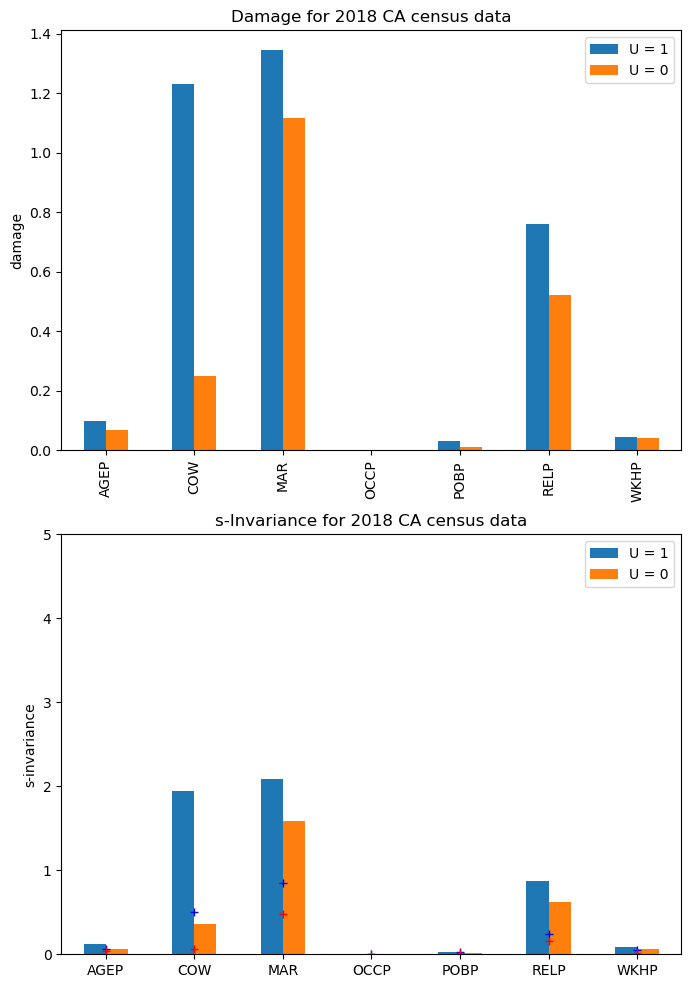

In [43]:
fig, axs = plt.subplots(2,1, figsize=(8,12))

# Data damage
report.iloc[::3,:2].plot.bar(ax=axs[0])

axs[0].set_xticklabels(report.index.get_level_values(0)[::3])

# handles, labels = axs[0].get_legend_handles_labels()
# axs[0].legend(handles, [f'U = {u}' for u in labels]) # Reverses the order

axs[0].set_title(f'Damage for {year} {state} census data')
axs[0].set_ylabel(f'damage')


# s-invariance
report.iloc[1::3,:2].plot.bar(ax=axs[1])

report.iloc[2::3,0].plot(ax=axs[1], style='+', c='blue', legend=False)
report.iloc[2::3,1].plot(ax=axs[1], style='+', c='red', legend=False)

axs[1].set_xticklabels(report.index.get_level_values(0)[1::3])

# axs[1].hlines(y=1, xmin=-1, xmax=7, colors='k', linestyles='dotted')

# handles, labels = axs[1].get_legend_handles_labels()
# axs[1].legend(handles, [f'U = {u}' for u in labels]) # Reverses the order

axs[1].set_title(f's-Invariance for {year} {state} census data')
axs[1].set_ylabel(f's-invariance')

axs[1].set_ylim((0,5))

fig.savefig(f'results/initial_forgetting_tests/{year}-{state}-no_forgetting-{epsilon}-{v_init}.png', bbox_inches='tight')

In [44]:
report.to_csv(f'results/initial_forgetting_tests/{year}-{state}-no_forgetting-{epsilon}-{v_init}.csv')

TO DO:
 - ~~Conduct repair based on stopping numbers~~
 - ~~Compile repaired on-sample and off-sample data~~
 - ~~Produce eval report for the compiled data~~
 - ~~PPrint eval report~~
 - ~~Plot results~~
 - Group code into class
 - Test on 2014 - 2023 ACSIncome data
 - ~~Util function to report representation bias~~
 - ~~Util function to compare stopping data to data distributions -- test ideal stopping params~~
 - Test on |U| > 2 -- split by education class??
***
 - Test Wasserstein s-Invariance and damage metrics -- cope with non-shared support??
 - Fix StoppingRepair code -- write a test to plot hists before/after repair? What could be breaking in the repair logic?

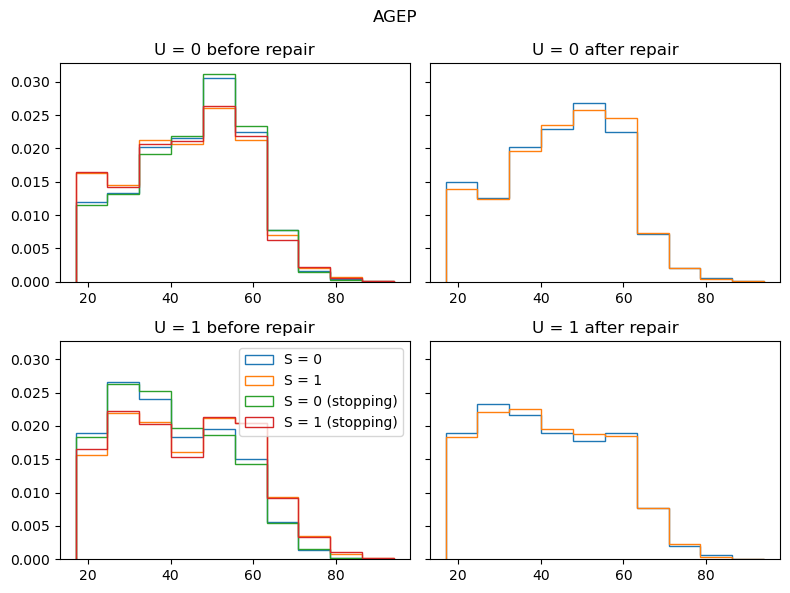

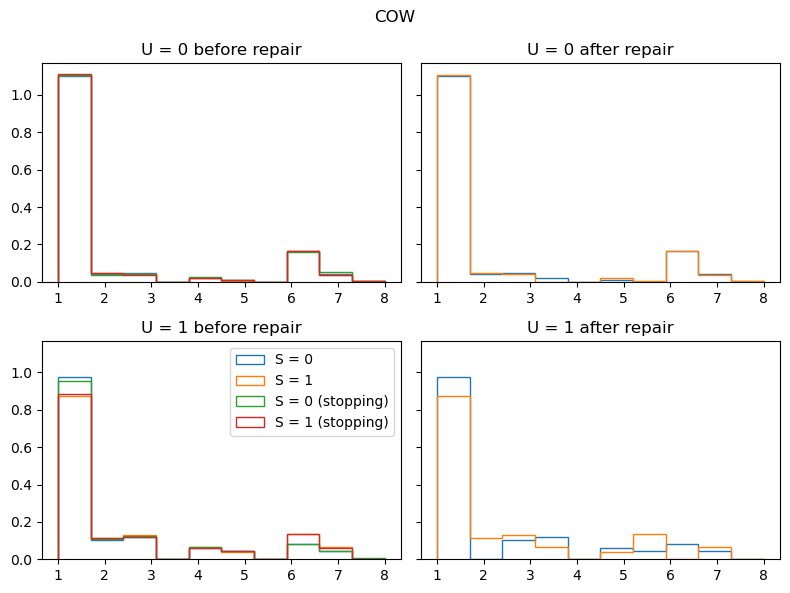

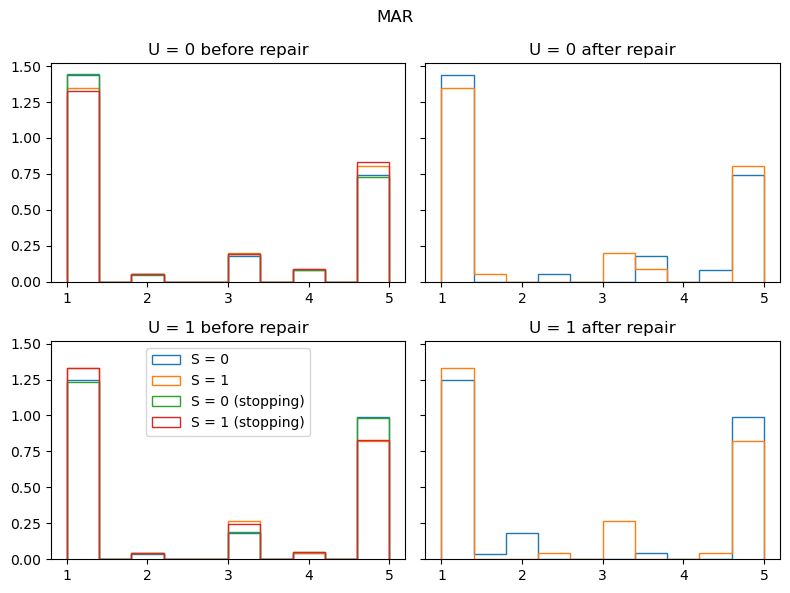

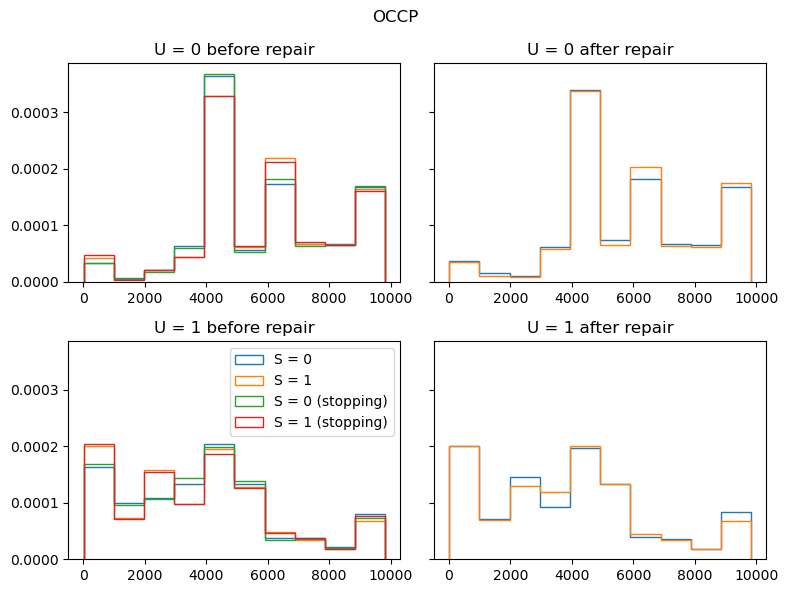

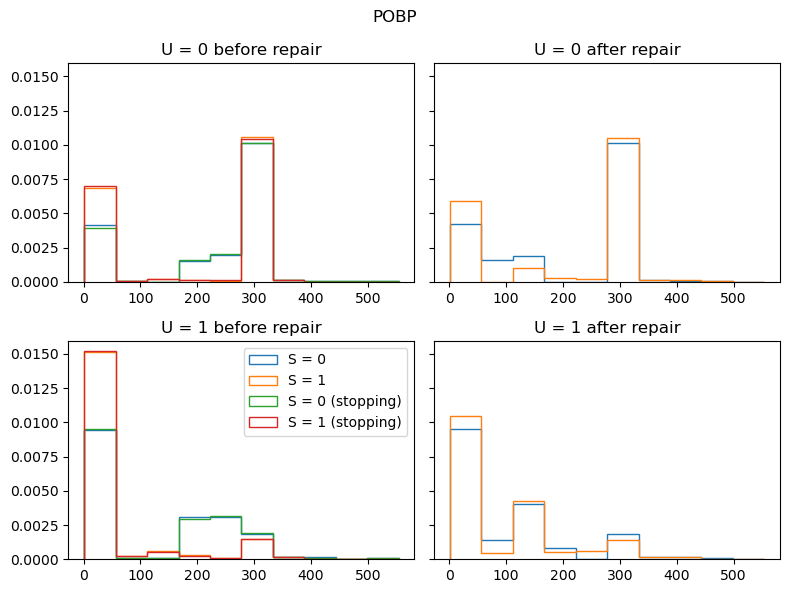

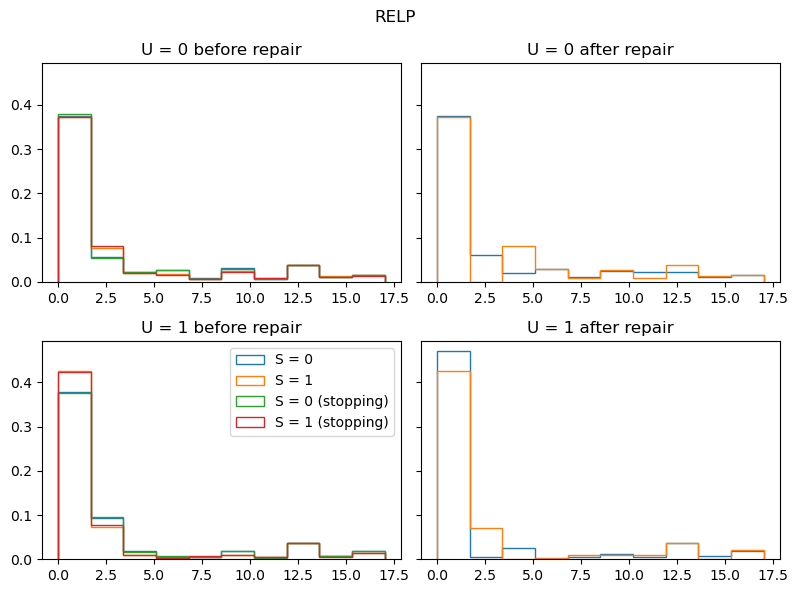

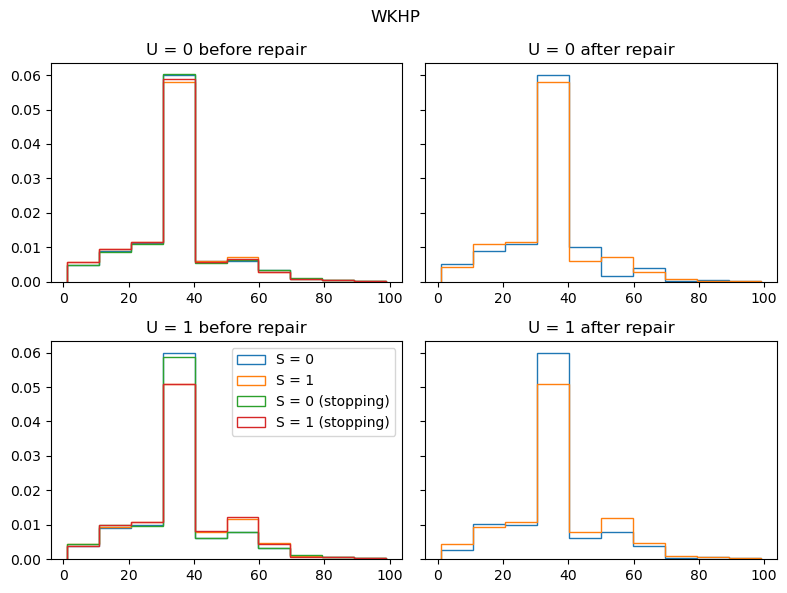

In [57]:
for f in features:

    fig, axs = plt.subplots(2, 2, figsize=(8,6), sharey=True)
    fig.suptitle(f)

    bins = np.histogram(data[f], bins=10)[1]

    for i, u in enumerate([0,1]):

        axs[i,0].hist(data[(data['u'] == u) & (data['s'] == 0)][f], bins=bins, histtype='step', density=True, label=f'S = {0}')
        axs[i,0].hist(data[(data['u'] == u) & (data['s'] == 1)][f], bins=bins, histtype='step', density=True, label=f'S = {1}')

        axs[i,0].hist(data[(data['u'] == u) & (data['s'] == 0)][f].iloc[0:int(rules[f][u][0].curr_rule.v)], bins=bins, histtype='step', density=True, label=f'S = {0} (stopping)')
        axs[i,0].hist(data[(data['u'] == u) & (data['s'] == 1)][f].iloc[0:int(rules[f][u][1].curr_rule.v)], bins=bins, histtype='step', density=True, label=f'S = {1} (stopping)')
        # axs[i,0].hist(stopping_data[(stopping_data['u'] == u) & (stopping_data['s'] == 0)][f], bins=10, histtype='step', density=True, label=f'S = {0} (stopping)')
        # axs[i,0].hist(stopping_data[(stopping_data['u'] == u) & (stopping_data['s'] == 1)][f], bins=10, histtype='step', density=True, label=f'S = {1} (stopping)')

        axs[i,1].hist(repaired_df[(repaired_df['u'] == u) & (repaired_df['s'] == 0)][f], bins=bins, histtype='step', density=True, label=f'S = {0}')
        axs[i,1].hist(repaired_df[(repaired_df['u'] == u) & (repaired_df['s'] == 1)][f], bins=bins, histtype='step', density=True, label=f'S = {1}')

        axs[i,0].set_title(f'U = {u} before repair')
        axs[i,1].set_title(f'U = {u} after repair')

    axs[i,0].legend()

    fig.tight_layout()